# Imports

In [1]:
import pyxdf
import pandas as pd
import numpy as np
from glob import glob
import datetime
import re
import matplotlib.pyplot as plt
from utils import *

# Load Data

In [2]:
sub_files = glob('/Users/camilla.strauss/Desktop/CUNY_Data/Data/*/*.xdf')

In [39]:
os.path.exists('/Users/camilla.strauss/Desktop/CUNY_Data/Data/sub-5182010/sub-5182010_ses-S001_task-CUNY_run-001_mobi.xdf')

True

In [38]:
'/Users/camilla.strauss/Desktop/CUNY_Data/Data/sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf'

'/Users/camilla.strauss/Desktop/CUNY_Data/Data/sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf'

In [41]:
sub_number = 2
xdf_path = sub_files[sub_number]
sub_id = xdf_path.split('/')[6].split('-')[1]
et_df = import_et_data(xdf_path)
stim_df = import_stim_data(xdf_path)

srate = 1/et_df.lsl_time_stamp.diff().median()

# Eye Tracking Data

In [6]:
# get percent valid items from validity columns
val_cols = et_df.filter(like = 'validity').columns
val_df = pd.DataFrame(columns = ['variable', 'percent_valid'])
val_df['variable'] = val_cols

for i, var in enumerate(val_cols):
    val_df.loc[i, 'percent_valid'] = round(np.mean(et_df[var]), 4)

val_df

,variable,percent_valid
0,left_gaze_origin_validity,0.4191
1,right_gaze_origin_validity,0.4458
2,left_gaze_point_validity,0.4098
3,right_gaze_point_validity,0.4441
4,left_pupil_validity,0.4098
5,right_pupil_validity,0.4441


In [7]:
# percent valid for all data columns (excluding time + validity columns)

# remove columns w validity or time data 
time_cols = et_df.filter(like = 'time').columns
qc_cols = time_cols.append(val_cols)
et_data_cols = et_df.columns.drop(qc_cols)

# percent non-NaN for each variable
et_qc = pd.DataFrame(columns= ['variable', 'percent_valid'])
et_qc['variable'] = et_data_cols

for i, var in enumerate(et_data_cols):
    et_qc.loc[i, 'percent_valid'] = round((1 - et_df[var].isna().mean()), 4)

et_qc

,variable,percent_valid
0,left_gaze_origin_in_user_coordinate_system_0,0.4191
1,left_gaze_origin_in_user_coordinate_system_1,0.4191
2,left_gaze_origin_in_user_coordinate_system_2,0.4191
3,right_gaze_origin_in_user_coordinate_system_0,0.4458
4,right_gaze_origin_in_user_coordinate_system_1,0.4458
5,right_gaze_origin_in_user_coordinate_system_2,0.4458
6,left_gaze_origin_in_trackbox_coordinate_system_0,0.4191
7,left_gaze_origin_in_trackbox_coordinate_system_1,0.4191
8,left_gaze_origin_in_trackbox_coordinate_system_2,0.4191
9,right_gaze_origin_in_trackbox_coordinate_system_0,0.4458


## Comparing Percents between Validity, Coordinates, and Coordinate Systems

In [8]:
# compare NaN percentage in each measure with validity 

# for each row of val_df
flag = False
for row in range(len(val_df)):
    # assign percent_valid to a var 
    val_percent = val_df.loc[row, 'percent_valid']

    # get name of 'variable' without _validity 
    searchable = val_df.loc[row, 'variable']
    searchable = searchable.replace('_validity', '')

    # find corresponding variable in et_qc
    found = et_qc[et_qc['variable'].str.contains(searchable)]

    # Check if floats are close enough to each other
    delta = 0.0000001
    for i in found.index:
        etqc_percent = found.loc[i, 'percent_valid']
        etqc_variable = found.loc[i, 'variable']
        diff = etqc_percent - val_percent
        
        if abs(diff) > delta:
            print("ERROR: {} and {} were different by a difference of {}.".format(etqc_variable, searchable, diff))
            flag = True
if not flag:
    print("validity variables equal % of present data for each measure")



validity variables equal % of present data for each measure


In [9]:
# compare coordinates (0,1,2)
flag_validity = True
for i in range(1, len(et_qc)):
    # get variables that end in numbers 
    root = re.sub(r"_\d+$", "", et_qc.loc[i, 'variable'])
    if root in et_qc.loc[i-1, 'variable']:
        current_percent = et_qc.loc[i, 'percent_valid']
        prev_percent = et_qc.loc[i-1, 'percent_valid']
        if current_percent != prev_percent:
            print("ERROR: {} does not equal {}!".format(et_qc.loc[i-1, 'variable'], et_qc.loc[i, 'variable']))
            flag_validity = False
if flag_validity:
    print("all coordinates have the same % validity within each measure (LR, gaze point/origin/diameter)")



all coordinates have the same % validity within each measure (LR, gaze point/origin/diameter)


In [10]:
# compare coordinate systems 

flag_nans = True
for i in range(1, len(et_qc)):
    root = et_qc.loc[i, 'variable'].split("_in")[0]
    root_percent = et_qc.loc[i, 'percent_valid']

    matching = et_qc[et_qc['variable'].str.contains(root)]

    for i in matching.index:
            matching_percent = matching.loc[i, 'percent_valid']
            matching_variable = matching.loc[i, 'variable']

            if root_percent != matching_percent:
                print("ERROR: {} and {} were different by a difference of {}.".format(matching_variable, root, (root_percent-matching_percent)))
                flag_nans = False
   
if flag_nans:
    print("% NaNs is the same between UCS and TBCS (gaze origin) and between UCS and display area (gaze point)")



% NaNs is the same between UCS and TBCS (gaze origin) and between UCS and display area (gaze point)


## Compare valid data between left and right eyes

In [11]:
left = et_qc[et_qc.variable.str.startswith('left')]
right = et_qc[et_qc.variable.str.startswith('right')]

RL_val = pd.DataFrame(columns = ['eye','min', 'max', 'mean'])

for i, (df, RL) in enumerate([(left, 'left'), (right, 'right')]):
    min1 = min(df['percent_valid'])
    max1 = max(df['percent_valid'])
    mean1 = round(np.mean(df['percent_valid']), 4)
    RL_val.loc[i] = [RL, min1, max1, mean1]

RL_val

,eye,min,max,mean
0,left,0.4098,0.4191,0.4144
1,right,0.4441,0.4458,0.4450


In [12]:
# find diff between RL 
RL_val.loc[2] = ['diff', RL_val['min'].diff()[1], RL_val['max'].diff()[1], RL_val['mean'].diff()[1]]

# add blank row 
blank = pd.DataFrame([['', '', '', '']], columns = RL_val.columns)
RL_val = pd.concat([RL_val.iloc[:2], blank, RL_val.iloc[2:]])
RL_val.reset_index(drop=True, inplace=True)
RL_val


,eye,min,max,mean
0,left,0.4098,0.4191,0.4144
1,right,0.4441,0.4458,0.445
2,,,,
3,diff,0.0343,0.0267,0.0306


In [13]:
lmean = RL_val.loc[RL_val.eye =='left', 'mean'][0]
rmean = RL_val.loc[RL_val.eye =='right', 'mean'][1]
mean_diff = RL_val.loc[RL_val.eye =='diff', 'mean'][3]

print('mean validity for left eye is {:.2%}.\n\
mean validity for right eye is {:.2%}.\n\
the difference is {:.2%}.'.format(lmean, rmean, abs(mean_diff)))

mean validity for left eye is 41.44%.
mean validity for right eye is 44.50%.
the difference is 3.06%.


## Gaze Point

### Min + Max

In [14]:
minmax = {}
for eye, e in zip(['left', 'right'], ['l', 'r']):
    for disp in ['0', '1']:
        minmax[f'min_{e}{disp}'] = round(np.nanmin(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)
        minmax[f'max_{e}{disp}'] = round(np.nanmax(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)
        
        # globals()['min_'+e+disp] = round(np.nanmin(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)
        # globals()['max_'+e+disp] = round(np.nanmax(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)


In [15]:
print(f"Left eye: \n\
      Display area 0 min: {minmax['min_l0']:.4}, max: {minmax['max_l0']:.4}\n\
      Display area 1 min: {minmax['min_l1']:.4}, max: {minmax['max_l1']:.4}\n\
      \n\
Right eye: \n\
      Display area 0 min: {minmax['min_r0']:.4}, max: {minmax['max_r0']:.4}\n\
      Display area 1 min: {minmax['min_r1']:.4}, max: {minmax['max_r1']:.4}")

# left and right eye display area 0 min pretty different

Left eye: 
      Display area 0 min: -1.575, max: 3.499
      Display area 1 min: -0.73, max: 2.154
      
Right eye: 
      Display area 0 min: -2.383, max: 2.358
      Display area 1 min: -0.885, max: 2.102


In [16]:
left_display = pd.DataFrame(columns = ['display area', 'min', 'max'])
right_display = pd.DataFrame(columns = ['display area', 'min', 'max'])

left_display.loc[0] = ['0', minmax['min_l0'], minmax['max_l0']]
left_display.loc[1] = ['1', minmax['min_l1'], minmax['max_l1']]

right_display.loc[0] = ['0', minmax['min_r0'], minmax['max_r0']]
right_display.loc[1] = ['1', minmax['min_r1'], minmax['max_r1']]

display(left_display)
display(right_display)

,display area,min,max
0,0,-1.575,3.499
1,1,-0.730,2.154


,display area,min,max
0,0,-2.383,2.358
1,1,-0.885,2.102


In [17]:
print(f"The difference between left and right is: \n\
      display area 0 min: {minmax['min_l0']-minmax['min_r0']:.3}, max: {minmax['max_l0']-minmax['max_r0']:.3} \n\
      display area 1 min: {minmax['min_l1']-minmax['min_r1']:.3}, max: {minmax['max_l1']-minmax['max_r1']:.3}")

The difference between left and right is: 
      display area 0 min: 0.808, max: 1.14 
      display area 1 min: 0.155, max: 0.052


(-3.0, 3.0)

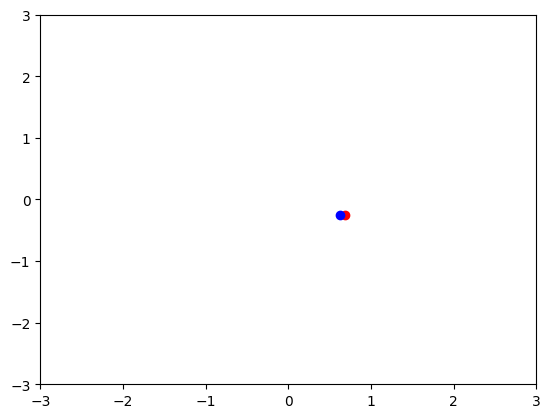

In [18]:
# plot L + R gaze points
plt.scatter(et_df.left_gaze_point_on_display_area_0[44], et_df.left_gaze_point_on_display_area_1[44], color = 'red')
plt.scatter(et_df.right_gaze_point_on_display_area_0[44], et_df.right_gaze_point_on_display_area_1[44], color = 'blue')
plt.xlim([-3,3])
plt.ylim([-3,3])

### Distance between gaze points

In [19]:
# remove NaNs
et_nums = et_df[~np.isnan(et_df.left_gaze_point_on_display_area_0) &
        ~np.isnan(et_df.left_gaze_point_on_display_area_1) &
        ~np.isnan(et_df.right_gaze_point_on_display_area_0) &
        ~np.isnan(et_df.right_gaze_point_on_display_area_1)]

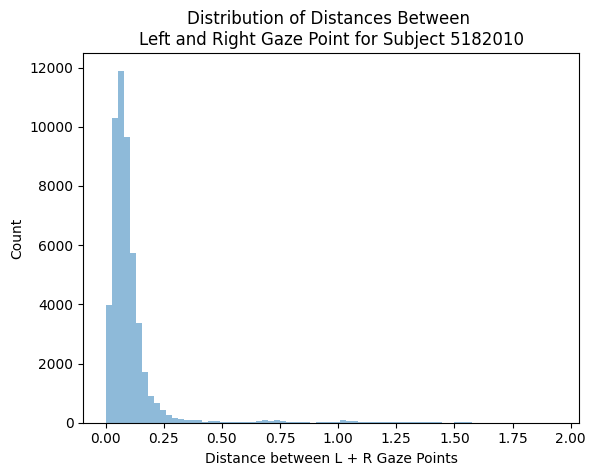

In [20]:
# distribution of distance between gaze points
x1 = et_nums.right_gaze_point_on_display_area_0
x2 = et_nums.left_gaze_point_on_display_area_0
y1 = et_nums.right_gaze_point_on_display_area_1
y2 = et_nums.left_gaze_point_on_display_area_1
dists = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

plt.hist(dists, bins =75, alpha = 0.5)
plt.title(f'Distribution of Distances Between \nLeft and Right Gaze Point for Subject {sub_id}')
plt.xlabel('Distance between L + R Gaze Points')
plt.ylabel('Count')
plt.show()


In [21]:
# percent of non NaN distances over 0.2
percent_over02 = sum(dists >= 0.2)/len(dists)

if percent_over02*100 > .5:
    print(f"{percent_over02:.3%} of Subject {sub_id}'s data has gaze points differences of over 0.2 mm(?)")

6.925% of Subject 5182010's data has gaze points differences of over 0.2 mm(?)


### Plot Distances over Time

In [22]:
sum(dists >= 0.2)/len(dists)

0.06925240446079106

In [23]:
sum(dists >= 0.2)

3521

In [24]:
# calculate distances including NaNs
x1 = et_df.right_gaze_point_on_display_area_0
x2 = et_df.left_gaze_point_on_display_area_0
y1 = et_df.right_gaze_point_on_display_area_1
y2 = et_df.left_gaze_point_on_display_area_1
all_dists = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
all_dists   

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
137765   NaN
137766   NaN
137767   NaN
137768   NaN
137769   NaN
Length: 137770, dtype: float32

percent over 0.20: 0.06925240446079106%


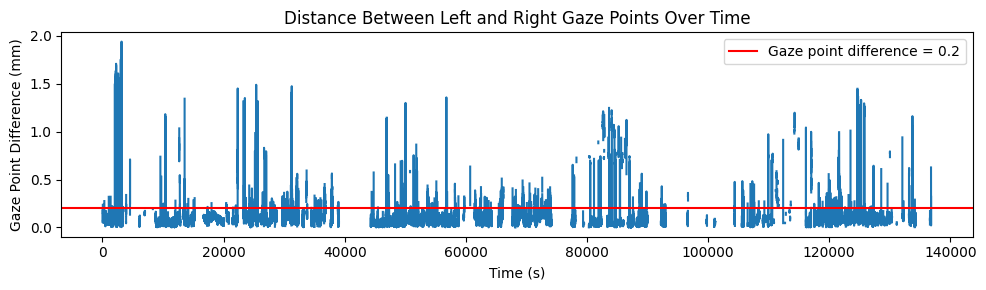

In [25]:
# plt w x = index 
plt.figure(figsize=(10, 3))
plt.plot(all_dists)
plt.title(f"Distance Between Left and Right Gaze Points Over Time")
plt.axhline(y = 0.2, color = 'red', label = 'Gaze point difference = 0.2')
plt.ylabel("Gaze Point Difference (mm)")
plt.xlabel("Time (s)")
plt.legend()
print(f"percent over 0.20: {percent_over02}%")
plt.tight_layout()
plt.savefig(f'report_images/{sub_id}_et_gazedifference.png')
plt.show()

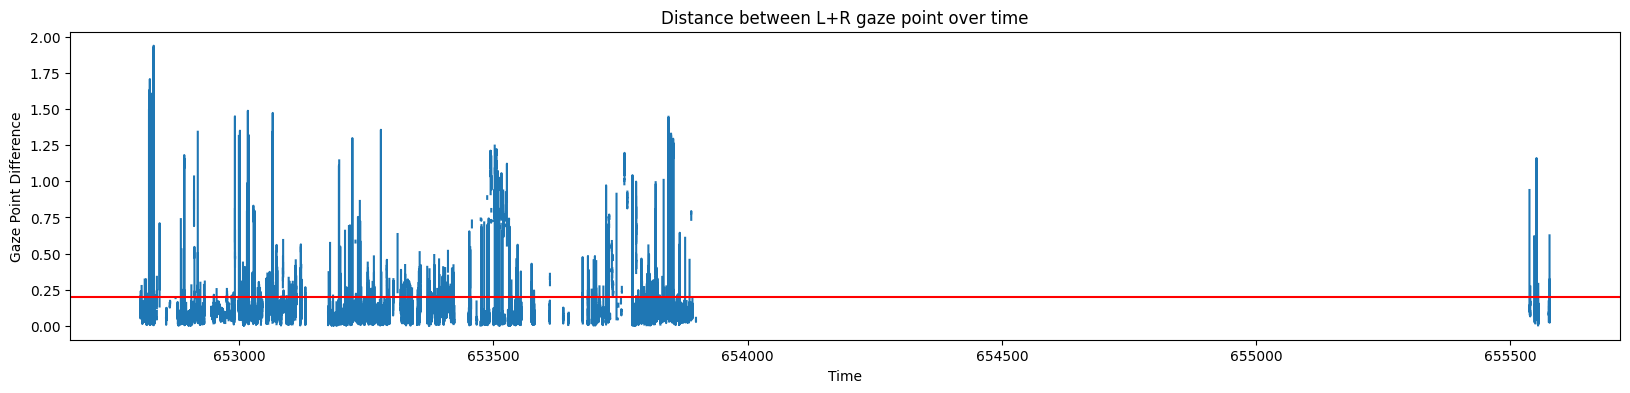

In [26]:
# plot with x = lsl time stamp
plt.figure(figsize=(20, 4))
plt.plot(et_df.lsl_time_stamp, all_dists)
plt.title(f"Distance between L+R gaze point over time")
plt.axhline(y = 0.2, color = 'red')
plt.ylabel("Gaze Point Difference")
plt.xlabel("Time")
plt.show()

## Compare R vs L validity across participants

In [27]:
def RL_percent(id):
    # load data
    num = [i for i, string in enumerate(sub_files) if id in string][0]
    xdf_path = sub_files[num]     
    data, header = pyxdf.load_xdf(xdf_path)
    streams_collected = [stream['info']['name'][0] for stream in data]

    # extract eye tracking data
    ET = data[streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]
    et_df = pd.DataFrame(data=et_dat, columns=column_labels)

    # get percent valid items from validity columns
    val_cols = et_df.filter(like = 'validity').columns
    val_df = pd.DataFrame(columns = ['variable', 'percent_valid'])
    val_df['variable'] = val_cols
    for i, var in enumerate(val_cols):
        val_df.loc[i, 'percent_valid'] = round(np.mean(et_df[var]), 4)

    # compare mean left and right validity
    left_df = val_df[val_df.variable.str.startswith('left')]
    right_df = val_df[val_df.variable.str.startswith('right')]   
    lmean = round(np.mean(left_df['percent_valid']), 4)
    rmean = round(np.mean(right_df['percent_valid']), 4)

    # format in a df for vibes 
    RL_val = pd.DataFrame(columns = ['eye', 'mean'])
    RL_val = RL_val.reindex([0,1]) # adds NaN rows w index 0 + 1
    RL_val.loc[[0, 1]] = [['left', lmean], ['right', rmean]]

    diff = rmean - lmean

    print('mean validity for left eye is {:.2%}.\n\
mean validity for right eye is {:.2%}.\n\
the difference is {:.2%}.'.format(lmean, rmean, abs(diff)))
    
    if diff > 0:
        print("right eye has higher validity than left.")
    else:
        print("left eye has higher validity than right.")

    return RL_val


In [28]:
# RL_percent("5182010")

In [29]:
# RL_percent("P5548165")

## Compare display area min + max across participants

In [30]:
def display_minmax(id):
    # load data
    num = [i for i, string in enumerate(sub_files) if id in string][0]
    xdf_path = sub_files[num]     
    data, header = pyxdf.load_xdf(xdf_path)
    streams_collected = [stream['info']['name'][0] for stream in data]

    # extract eye tracking data
    ET = data[streams_collected.index('Tobii')]
    et_dat = ET['time_series']
    column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]
    et_df = pd.DataFrame(data=et_dat, columns=column_labels)

    # get 
    minmax = {}
    for eye, e in zip(['left', 'right'], ['l', 'r']):
        for disp in ['0', '1']:
            minmax[f'min_{e}{disp}'] = round(np.nanmin(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)
            minmax[f'max_{e}{disp}'] = round(np.nanmax(et_df['{}_gaze_point_on_display_area_{}'.format(eye, disp)]), 3)

    left_display = pd.DataFrame(columns = ['display area', 'min', 'max'])
    right_display = pd.DataFrame(columns = ['display area', 'min', 'max'])

    left_display.loc[0] = ['0', minmax['min_l0'], minmax['max_l0']]
    left_display.loc[1] = ['1', minmax['min_l1'], minmax['max_l1']]
    right_display.loc[0] = ['0', minmax['min_r0'], minmax['max_r0']]
    right_display.loc[1] = ['1', minmax['min_r1'], minmax['max_r1']]

    print("left:")
    display(left_display)
    print("\nright:")
    display(right_display)

    print(f"The difference between left and right is: \n\
      display area 0 min: {minmax['min_l0']-minmax['min_r0']:.3}, max: {minmax['max_l0']-minmax['max_r0']:.3} \n\
      display area 1 min: {minmax['min_l1']-minmax['min_r1']:.3}, max: {minmax['max_l1']-minmax['max_r1']:.3}")





In [31]:
# display_minmax("P5318014")

In [32]:
# display_minmax("P5548165")

In [33]:
# display_minmax("5182010")

# Reported Metrics

In [42]:
print(f'effective sampling rate: {srate:.3f}')
print(f'Flag: all coordinates have the same % validity within each measure (LR, gaze point/origin/diameter): {flag_validity}')
print(f'Flag: % of NaNs is the same between UCS and TBCS (gaze origin) and between UCS and display area (gaze point): {flag_nans}')
print(f'Mean difference in percent valid data between right and left eyes: {abs(mean_diff):.3%}')
print(f'Percent of data with gaze point differences of over 0.2 mm: {percent_over02:.3%}')


effective sampling rate: 119.996
Flag: all coordinates have the same % validity within each measure (LR, gaze point/origin/diameter): True
Flag: % of NaNs is the same between UCS and TBCS (gaze origin) and between UCS and display area (gaze point): True
Mean difference in percent valid data between right and left eyes: 3.060%
Percent of data with gaze point differences of over 0.2 mm: 6.925%


In [40]:
et_df

,device_time_stamp,left_gaze_origin_validity,right_gaze_origin_validity,left_gaze_origin_in_user_coordinate_system_0,left_gaze_origin_in_user_coordinate_system_1,left_gaze_origin_in_user_coordinate_system_2,right_gaze_origin_in_user_coordinate_system_0,right_gaze_origin_in_user_coordinate_system_1,right_gaze_origin_in_user_coordinate_system_2,left_gaze_origin_in_trackbox_coordinate_system_0,...,left_gaze_point_on_display_area_1,right_gaze_point_on_display_area_0,right_gaze_point_on_display_area_1,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,lsl_time_stamp,time,diff
0,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.459065,0.000000,NaN
1,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.467398,0.008334,0.008334
2,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.475732,0.016667,0.008334
3,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.484066,0.025001,0.008334
4,1.667686e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,652805.492399,0.033334,0.008334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137765,1.670466e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,655585.084729,2779.625664,0.008334
137766,1.670466e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,655585.093062,2779.633998,0.008334
137767,1.670466e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,655585.101396,2779.642331,0.008334
137768,1.670466e+12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,655585.109730,2779.650665,0.008334
